In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import nltk
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Data Preprocessing

In [2]:
from tensorflow.keras.datasets import reuters
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer

In [49]:
(X_train, y_train), (X_test, y_test) = reuters.load_data() # skip_top=100)
print(X_train.size)
print(X_test.size)

8982
2246


In [4]:
"""
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')
"""

In [50]:
x = X_train[0]
y = y_train[0]
print(x)
print(y)

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
3


In [6]:
reverse_index = {v : k for (k, v) in reuters.get_word_index().items()}
NUM_OF_WORDS = len(reverse_index) + 3

In [7]:
# skip "padding", "start of sequence", and "unknown"
decoded_x = ' '.join([reverse_index.get(i - 3, '?') for i in x])
decoded_x

'? mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

Building a __validation__ set:

In [37]:
"""
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_index, test_index in split.split(X_train, y_train):
    X_train_set = X_train[train_index]
    y_train_set = y_train[train_index]
    X_valid_set = X_train[test_index]
    y_valid_set = y_train[test_index]
"""

In [38]:
"""
print(X_train_set.size)
print(X_valid_set.size)
"""

7634
1348


Glance at the __categories__:

In [8]:
unique, counts = np.unique(y_train, return_counts=True)
df = pd.DataFrame({'label':unique, 'docs':counts})
df.set_index('label', inplace=True)
df.head(5)

,docs
label,
0.0,55
1.0,432
2.0,74
3.0,3159
4.0,1949


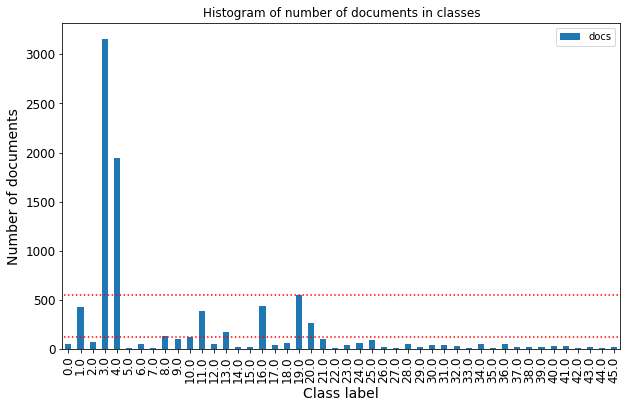

In [9]:
df.plot(kind='bar', figsize=(10, 6))
plt.plot([-1 , 46], [120, 120], "r:") 
plt.plot([-1 , 46], [550, 550], "r:") 
plt.title('Histogram of number of documents in classes')
plt.ylabel('Number of documents')
plt.xlabel('Class label')
plt.show()

In [10]:
group_names = ['Small', 'Medium', 'Large']
bins = [0, 120, 550, 3500]
df['size'] = pd.cut(df['docs'], bins, labels=group_names, include_lowest=True)
df.head()

,docs,size
label,,
0.0,55,Small
1.0,432,Medium
2.0,74,Small
3.0,3159,Large
4.0,1949,Large


Text(0.5, 0, 'Class size')

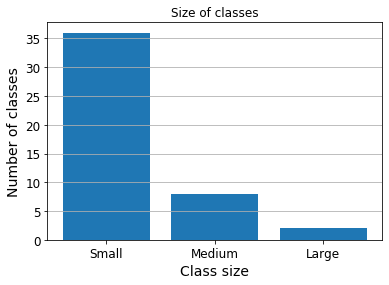

In [11]:
plt.bar(group_names, df['size'].value_counts())
plt.gca().yaxis.grid(True)
plt.title('Size of classes')
plt.ylabel('Number of classes')
plt.xlabel('Class size')

__Important__: There are two classes, which are significantly large, then others. The size of the classes should be more balanced to escape the bias. 

In [12]:
class MultinomialVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, words_count): # no *args or **kargs
        self.words_count = words_count
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        results = np.zeros(shape=(len(X), self.words_count))
        for i, x in enumerate(X):
            results[i, x] += 1.0
        return results

In [13]:
class BernoulliVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, words_count): # no *args or **kargs
        self.words_count = words_count
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, X):
        results = np.zeros(shape=(len(X), self.words_count))
        for i, x in enumerate(X):
            results[i, x] = 1.0
        return results

In [14]:
vector_pipeline = Pipeline([
        ('vectorizer', BernoulliVectorizer(words_count=NUM_OF_WORDS)),
        #('std_scaler', StandardScaler()),
        ('normalizer', Normalizer(norm='l1'))
    ])

In [51]:
%%time
#X_train_set = vector_pipeline.fit_transform(X_train_set)
#X_valid_set = vector_pipeline.fit_transform(X_valid_set)
X_train = vector_pipeline.fit_transform(X_train)

Wall time: 4.35 s


## Model Selection

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [17]:
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers, losses, metrics

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, cross_val_predict

In [19]:
def my_plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    ax.set_xticks(unique)
    ax.set_xlabel('Predicted label')
    ax.set_yticks(unique)
    ax.set_ylabel('True label')
    plt.xticks(rotation=90)
    fig.colorbar(cax)

In [20]:
def my_plot_history(history, param_name):
    plt.plot(history[param_name], 'b')
    plt.plot(history['val_' + param_name], 'bo')
    short_name = param_name.split('_')[-1].capitalize()
    plt.title('Model '+ short_name)
    plt.ylabel(short_name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

### 1. Logistic regression

In [21]:
lr = LogisticRegression(C=0.01, solver='liblinear')

In [22]:
%%time
y_pred_lr = cross_val_predict(lr, X_train, y_train, cv=3)
cm_lr = confusion_matrix(y_train, y_pred_lr)
cm_lr

Wall time: 11.1 s


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [23]:
row_sums = cm_lr.sum(axis=1, keepdims=True)
norm_cm = cm_lr / row_sums
#np.fill_diagonal(norm_cm, 0)

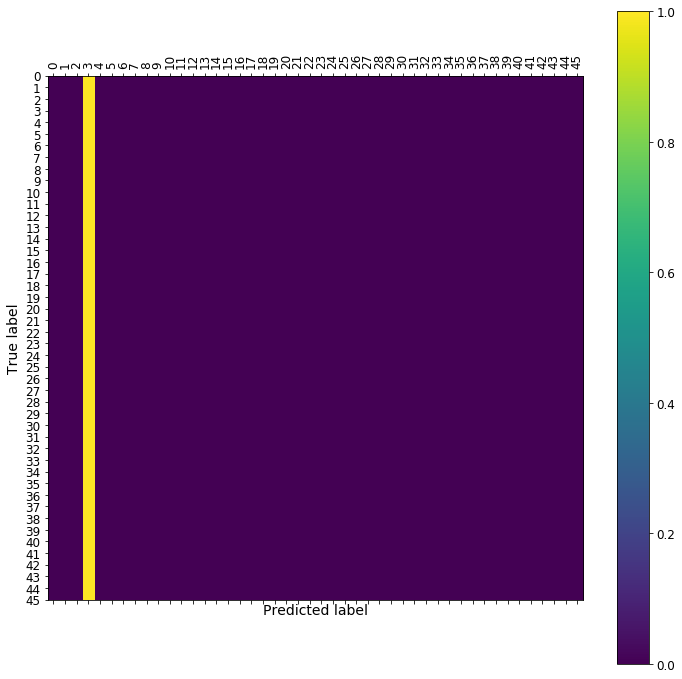

In [24]:
my_plot_confusion_matrix(norm_cm)

__AAAhh!__ It selects the most 'significant' class and suppose, every document should be in it.

In [25]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

In [30]:
lr

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
%%time
y_pred_lr_ovr = cross_val_predict(OneVsOneClassifier(lr), X_train, y_train, cv=3)
cm_lr_ovr = confusion_matrix(y_train, y_pred_lr_ovr)
cm_lr_ovr

Wall time: 2min 14s


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

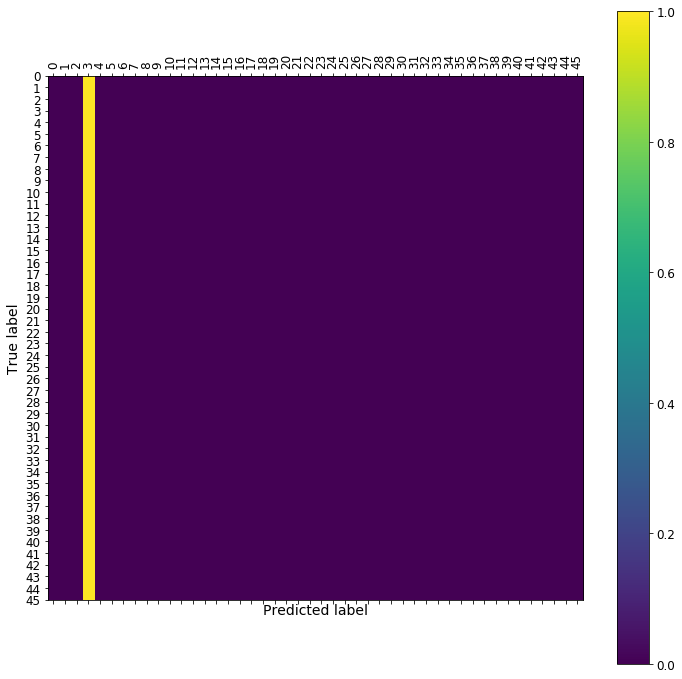

In [29]:
row_sums = cm_lr_ovr.sum(axis=1, keepdims=True)
norm_cm = cm_lr_ovr / row_sums
my_plot_confusion_matrix(norm_cm)

Same (((

### 2. Random Forest

In [32]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=2)

In [33]:
%%time
y_pred_rf = cross_val_predict(rf, X_train, y_train, cv=3)
cm_rf = confusion_matrix(y_train, y_pred_rf)
cm_rf

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]:

Wall time: 57.2 s


array([[ 18,   5,   0, ...,   0,   0,   0],
       [  1, 332,   0, ...,   0,   0,   0],
       [  0,  16,  14, ...,   0,   0,   0],
       ...,
       [  0,   1,   0, ...,   4,   0,   0],
       [  0,   0,   0, ...,   0,   9,   0],
       [  0,   1,   0, ...,   0,   0,   7]], dtype=int64)

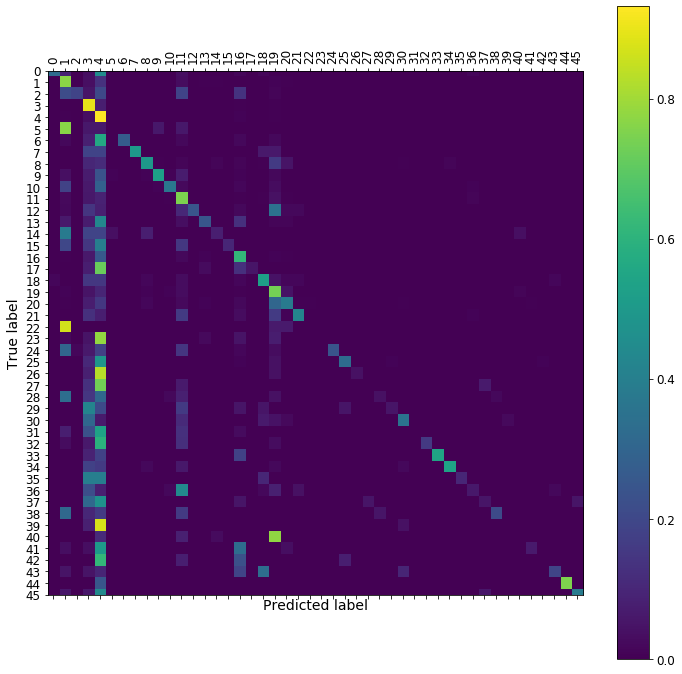

In [34]:
row_sums = cm_rf.sum(axis=1, keepdims=True)
norm_cm = cm_rf / row_sums
#np.fill_diagonal(norm_cm, 0)
my_plot_confusion_matrix(norm_cm)

In [35]:
%%time
scores_rf = cross_validate(rf, X_train, y_train, cv=3, 
                           scoring=['accuracy', 'precision_micro', 'recall_micro', 'f1_micro'])
scores_rf

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]:

Wall time: 55.3 s


{'fit_time': array([17.07720971, 17.96156836, 18.3681612 ]),
 'score_time': array([0.40441489, 0.44788957, 0.42417479]),
 'test_accuracy': array([0.72979292, 0.72110888, 0.73647295]),
 'test_precision_micro': array([0.72979292, 0.72110888, 0.73647295]),
 'test_recall_micro': array([0.72979292, 0.72110888, 0.73647295]),
 'test_f1_micro': array([0.72979292, 0.72110888, 0.73647295])}

### 3. NN

In [45]:
model = models.Sequential()
model.add(layers.Dense(10000, activation='relu', input_shape=(NUM_OF_WORDS,)))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(len(unique), activation='sigmoid'))

In [47]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              #loss=losses.mean_squared_error,
              metrics=[metrics.categorical_accuracy])

In [54]:
from tensorflow.keras.utils import to_categorical
y_binary = to_categorical(y_train)

In [ ]:
#sparse_categorical_crossentropy

In [63]:
%%time
history = model.fit(X_train, y_binary, validation_split=0.15,
                    epochs=10, batch_size=1600)

Train on 7634 samples, validate on 1348 samples
Epoch 1/10
7634/7634 [==============================] - 60s 8ms/sample - loss: 1.3086 - categorical_accuracy: 0.6390 - val_loss: 1.3037 - val_categorical_accuracy: 0.6884
Epoch 2/10
7634/7634 [==============================] - 61s 8ms/sample - loss: 1.0380 - categorical_accuracy: 0.7291 - val_loss: 1.2731 - val_categorical_accuracy: 0.6981
Epoch 3/10
7634/7634 [==============================] - 61s 8ms/sample - loss: 0.9628 - categorical_accuracy: 0.7447 - val_loss: 1.2437 - val_categorical_accuracy: 0.6907
Epoch 4/10
7634/7634 [==============================] - 62s 8ms/sample - loss: 1.0901 - categorical_accuracy: 0.6793 - val_loss: 1.1486 - val_categorical_accuracy: 0.7315
Epoch 5/10
7634/7634 [==============================] - 61s 8ms/sample - loss: 0.8044 - categorical_accuracy: 0.7832 - val_loss: 1.1208 - val_categorical_accuracy: 0.7433
Epoch 6/10
7634/7634 [==============================] - 60s 8ms/sample - loss: 0.7431 - categoric

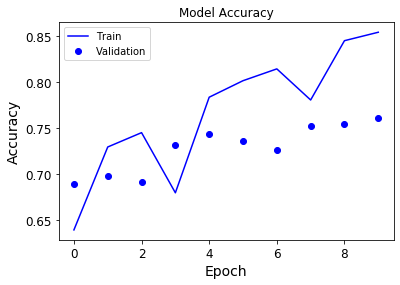

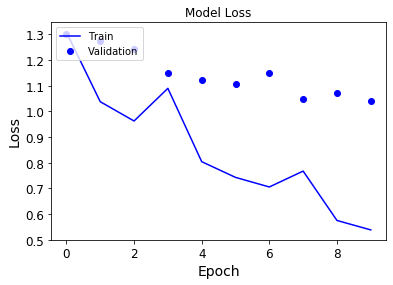

In [64]:
my_plot_history(history.history, 'categorical_accuracy')
my_plot_history(history.history, 'loss')

In [65]:
y_hat = model.predict(X_train)

In [79]:
y_pred_nn = np.argmax(y_hat, axis=1)

In [80]:
cm_nn = confusion_matrix(y_train, y_pred_nn)
cm_nn

array([[ 13,   1,   0, ...,   0,   0,   0],
       [  0, 408,   0, ...,   0,   0,   0],
       [  0,  12,  40, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int64)

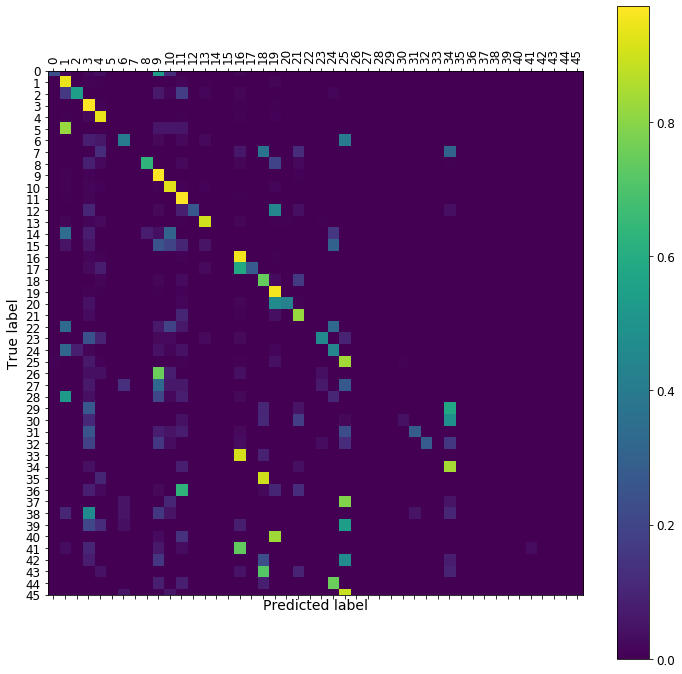

In [81]:
row_sums = cm_nn.sum(axis=1, keepdims=True)
norm_cm = cm_nn / row_sums
my_plot_confusion_matrix(norm_cm)